# Make Violin Plot of ROHs in ancient Individuals
Load and Plot Summary Statistics of IBD block sharing in ancient Individuals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)

if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
    print("Harald's Machine Detected")
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

midway2-0401.rcc.local
Midway jnovmbre partition detected.


In [2]:
### Read the Meta File
meta_path = "./Data/Marcus2019_1240k/meta_rev_final.csv"
#meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File
anc_sardind= 85
anc_ind =  1087

In [4]:
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df_roh_info = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df_roh_info)} Individuals")

full_df = pd.merge(df_roh_info, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")
group_df = full_df.groupby("clst")  # Group by Population

Loaded 557 Individuals


### Show Populations with many individuals

In [7]:
counts = full_df["clst"].value_counts()
pops_high = counts[counts>3].index.values
pops_high

array(['CE-EBA', 'Balkans-MNCA', 'GB-EBA', 'Balkans-BA', 'Iron_Gates-HG',
       'GB-LBA', 'GB-LN', 'CE-LBA', 'Sar-EMBA', 'Anatolia-N', 'Latvia-HG',
       'CE-EN', 'Sar-Nur', 'Balkans-EN', 'Steppe-EMBA', 'Netherlands-BA',
       'GB-EN', 'Steppe-MLBA', 'Ukraine-N', 'Iberia-ECA', 'Iberia-LCA',
       'Iberia-BA', 'CE-MNCA', 'SHG-HG', 'Greece-N', 'Ukraine-CA',
       'Ukraine-HG', 'Minoan-BA', 'Latvia-MN', 'Iberia-EN', 'Armenia-CA',
       'Sar-Pun', 'Iran-CA'], dtype=object)

In [23]:
def plot_roh_violin(roh_vecs, pop_labels, colors, fs=16, savepath = "./figures_test/violins_data.pdf", ylim=[0,140],
                   rot_label=45):
    """Do Violin Plots of ROH.
    group_df: Grouped Pandas Dataframe of ROH sharing
    pops_ordered: List of populations to plot
    colors: List of Colors of Violin plot (same length as pops_ordered)"""
    fs=16
    figsize=(16,6)
    plt.figure(figsize=figsize)
    ax = plt.gca()  # Get the axis Object

    #ax.set_title()
    parts = ax.violinplot(roh_vecs, showmeans=False, 
                           showmedians=False, showextrema=False, widths=0.6)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    quartiles = np.array([np.percentile(vec, [25, 50, 75]) for vec in roh_vecs])
    quartile1, medians, quartile3 = quartiles[:,0], quartiles[:,1], quartiles[:,2]

    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', color='yellow', s=20, zorder=3, label="Median")
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5, label="25-75% Quartile")
    ax.legend(loc="upper right", fontsize=fs)
    # set style for the axes

    ### Do the X-Axis Label
    ax.get_xaxis().set_tick_params(direction='out', rotation=rot_label)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(pop_labels) + 1))
    ax.set_xticklabels(pop_labels, fontsize=fs*0.8)
    ax.set_xlim(0.25, len(pop_labels) + 0.75)

    ### Do the Y-Axis
    #ax.ytick(fontsize=fs)
    ax.set_ylabel("Sum Block Sharing >4cM", fontsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    ax.set_ylim(ylim)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")
    plt.show()
    
def get_summary_roh(group_df, pop):
    """Return Array of Total Lengths of ROH>4cm in Population"""
    df_temp = group_df.get_group(pop)
    sum_rohs = df_temp["sum_roh"].values
    return sum_rohs

def sort_rohs(roh_vecs):
    """Return Indices of ROH sharing, sorted from most to least.
    Sorts by Median. Tie breaker: 75 Quartile"""
    
    quartiles = np.array([np.percentile(vec, [25, 50, 75]) for vec in roh_vecs])
    quartile1, medians, quartile3 = quartiles[:,0], quartiles[:,1], quartiles[:,2]
    ind = np.lexsort((quartile1, quartile3, medians))
    return ind

Saved to ./figures/talk_harvard/violin_ancs.pdf


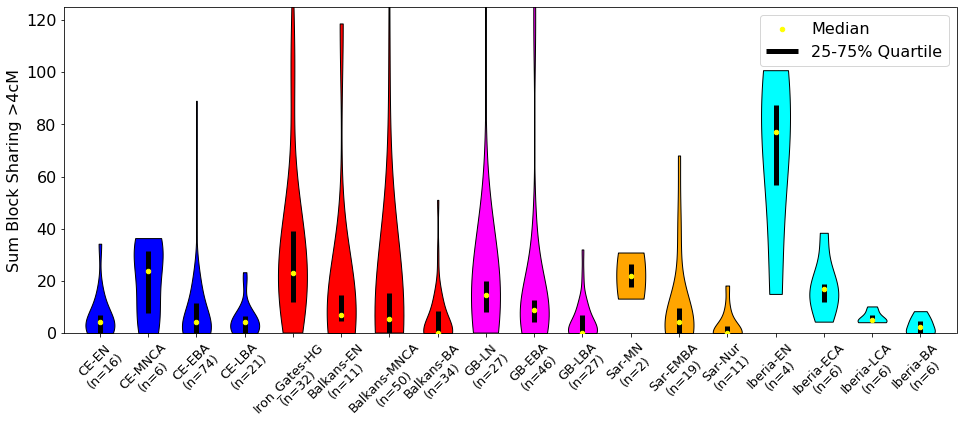

In [15]:
### A ordered List of interesting populations
pops_ordered = ["CE-EN", "CE-MNCA", "CE-EBA", "CE-LBA", "Iron_Gates-HG", "Balkans-EN", "Balkans-MNCA", "Balkans-BA", "GB-LN", 
                "GB-EBA","GB-LBA", "Sar-MN", "Sar-EMBA", "Sar-Nur", "Iberia-EN", "Iberia-ECA", "Iberia-LCA", "Iberia-BA"] #"Anatolia-N"
colors = ["blue"] * 4 + ["red"] * 4 + ["magenta"] * 3 + ["orange"] * 3 + ["cyan"] * 4


roh_vecs = [get_summary_roh(group_df, pop) for pop in pops_ordered]
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs]
pop_labels = [pops_ordered[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))]

plot_roh_violin(roh_vecs, pop_labels, colors, savepath = "./figures/talk_harvard/violin_ancs.pdf", ylim=[0, 125])

## Plot HG vrs Neolithic Pops

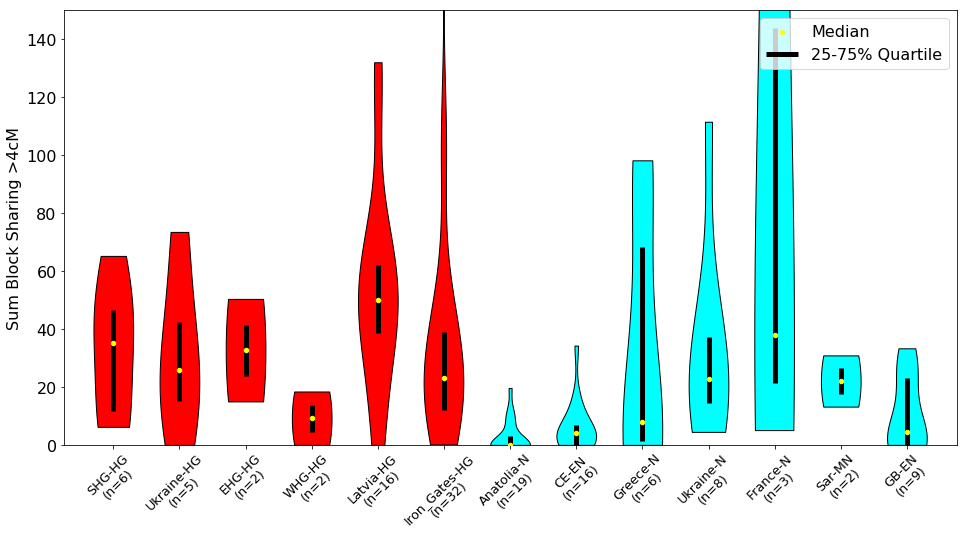

In [14]:
### A ordered List of interesting populations
pops_hg = ["SHG-HG", "Ukraine-HG", "EHG-HG", "WHG-HG", "Latvia-HG", "Iron_Gates-HG"]
pop_nlth = ["Anatolia-N", "CE-EN", "Greece-N", "Ukraine-N", "France-N", "Sar-MN", "GB-EN"]

pops_ordered = pops_hg + pop_nlth

colors = ["red"] * len(pops_hg) + ["cyan"] * len(pop_nlth)
roh_vecs = [get_summary_roh(group_df, pop) for pop in pops_ordered]
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs]
pop_labels = [pops_ordered[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))]

plot_roh_violin(group_df, pops_ordered, colors, savepath = "")

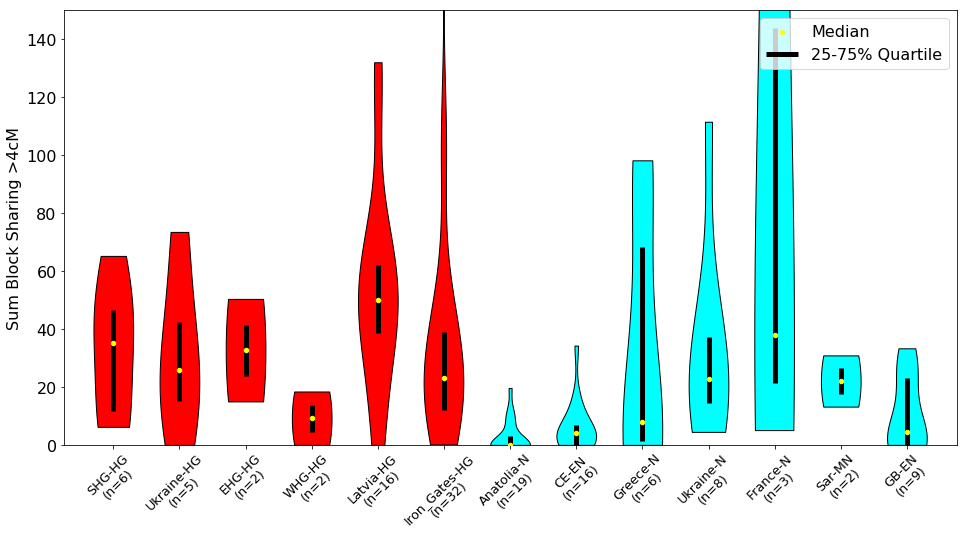

In [26]:
full_df = pd.merge(df_roh_info, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")
group_df = full_df.groupby("clst")  # Group by Population

### A ordered List of interesting populations
pops_hg = ["SHG-HG", "Ukraine-HG", "EHG-HG", "WHG-HG", "Latvia-HG", "Iron_Gates-HG"]
pop_nlth = ["Anatolia-N", "CE-EN", "Greece-N", "Ukraine-N", "France-N", "Sar-MN", "GB-EN"]


pops_ordered = pops_hg + pop_nlth


colors = ["red"] * len(pops_hg) + ["cyan"] * len(pop_nlth)
roh_vecs = [get_summary_roh(group_df, pop) for pop in pops_ordered]
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs]
pop_labels = [pops_ordered[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))]

plot_roh_violin(group_df, pops_ordered, colors, savepath = "")



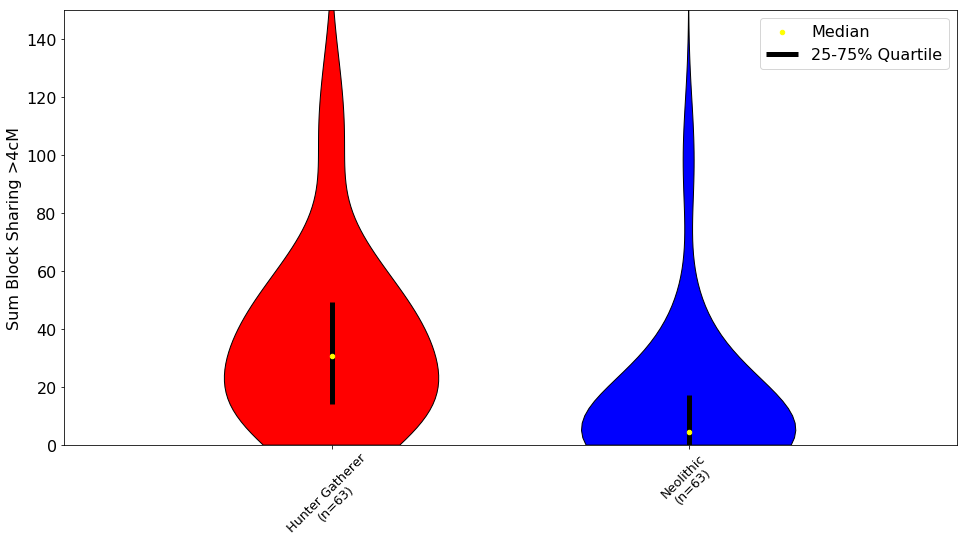

In [24]:
pops_hg = ["SHG-HG", "Ukraine-HG", "EHG-HG", "WHG-HG", "Latvia-HG", "Iron_Gates-HG"]
pop_nlth = ["Anatolia-N", "CE-EN", "Greece-N", "Ukraine-N", "France-N", "Sar-MN", "GB-EN"]

full_df.loc[full_df["clst"].isin(pops_hg), "clst"] = "Hunter Gatherer"
full_df.loc[full_df["clst"].isin(pop_nlth), "clst"] = "Neolithic"

pops_ordered = ["Hunter Gatherer", "Neolithic"]
colors = ["red", "blue"]

group_df = full_df.groupby("clst")  # Group by Population

roh_vecs = [get_summary_roh(group_df, pop) for pop in pops_ordered]
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs]

pop_labels = [pops_ordered[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))]
plot_roh_violin(group_df, pops_ordered, colors, savepath = "")


### Plot Modern Populations

Loaded 250 Individuals


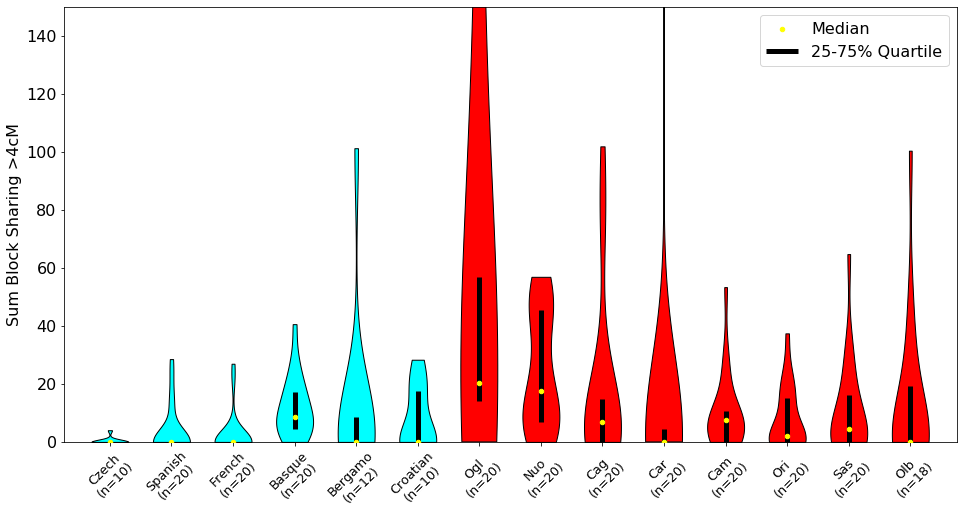

In [17]:
### A ordered List of interesting populations
path_rohs_info_mod = "./Empirical/1240k/modern_roh_summary.csv"
df_roh_info = pd.read_csv(path_rohs_info_mod)
print(f"Loaded {len(df_roh_info)} Individuals")

### Load Modern Meta
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File
full_df = pd.merge(df_roh_info, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")
group_df = full_df.groupby("clst")  # Group by Population

pop_list = ["Czech", 'Spanish', 'French', "Basque", "Bergamo", 'Croatian', "Ogl", "Nuo", "Cag", "Car", "Cam", "Ori", "Sas", "Olb"]
colors_mod = ["cyan"] * 6+ ["red"] * 8

roh_vecs_mod = [get_summary_roh(group_df, pop) for pop in pop_list]
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs_mod]
pop_labels_mod = [pop_list[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))]

plot_roh_violin(roh_vecs_mod, pop_labels_mod, colors_mod, savepath = "")

In [11]:
meta_df[meta_df["clst"]=="Czech"]

,iid,label,lat,lon,x_contam,mt_contam,age,study,clst_alt,period_alt,include_alt,clst,mean_cov,med_cov,n_cov_snp_read,full_iid,n_cov_snp
2435,NA1572,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15725,555018
2436,NA1573,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15733,554937
2446,NA1572,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15726,554808
2457,NA1572,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15727,554954
2466,NA1572,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15728,554491
2476,NA1572,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15729,555463
2486,NA1573,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15730,555311
2496,NA1573,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15731,555136
2504,NA1572,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15724,554925
2505,NA1573,Czech,50.1,14.4,NaN,NaN,0.0,Lazaridis et al. 2014,Czech,NaN,1,Czech,NaN,NaN,NaN,NA15732,555177


## Do a combined Plot

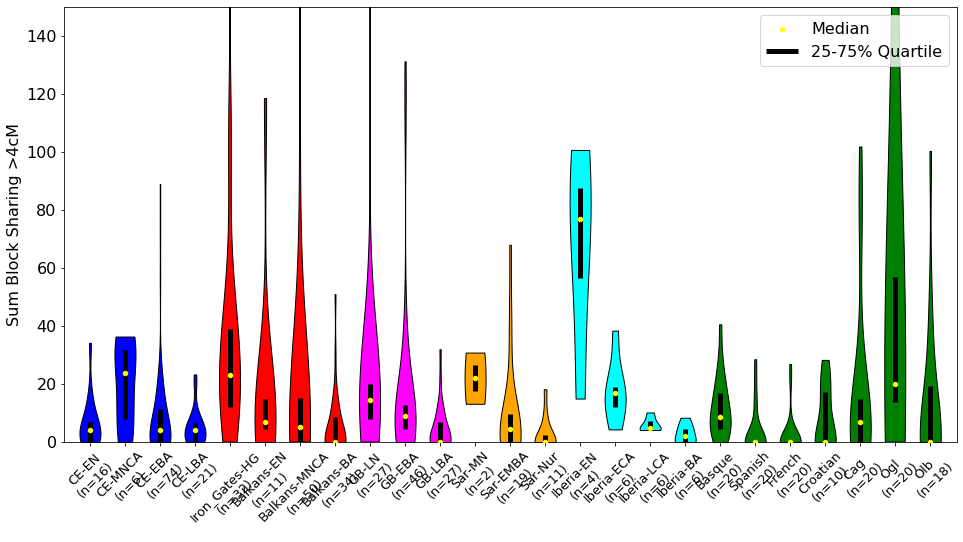

In [28]:
plot_roh_violin(roh_vecs + roh_vecs_mod, pop_labels + pop_labels_mod, colors + colors_mod, savepath = "")

Loaded 308 Individuals


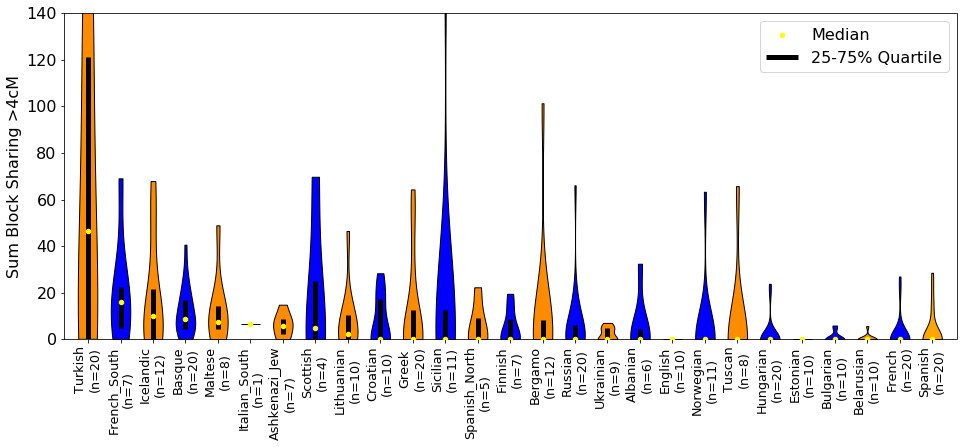

In [28]:
### A ordered List of interesting populations
path_rohs_info_mod = "./Empirical/1240k/HO_roh_summary.csv"
df_roh_info = pd.read_csv(path_rohs_info_mod)
print(f"Loaded {len(df_roh_info)} Individuals")

### Load Modern Meta
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File
full_df = pd.merge(df_roh_info, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")
group_df = full_df.groupby("clst")  # Group by Population

#pop_list = ["Czech", 'Spanish', 'French', "Basque", "Bergamo", 'Croatian', "Ogl", "Nuo", "Cag", "Car", "Cam", "Ori", "Sas", "Olb"]
pop_list = ["Basque", "Bergamo", 'Spanish', 'French', 'Croatian', 'Albanian',  'Ashkenazi_Jew', 'Belarusian', 'Bulgarian', 'Estonian', 'Finnish', 'French_South', 'Hungarian', 
            'Lithuanian', 'Maltese', 'Russian', 'Scottish', 'Spanish_North', 'Turkish', 'Tuscan', 'Ukrainian',
           "Italian_South", "Sicilian", "Icelandic", "Norwegian", "English", "Greek"]

colors_mod = ["darkorange", "blue"] * (len(pop_list)//2) + ["orange"] * (len(pop_list) % 2)

roh_vecs_mod = np.array([get_summary_roh(group_df, pop) for pop in pop_list])
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs_mod]
pop_labels_mod = np.array([pop_list[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))])

### Sort by ROH Sharing
inds = sort_rohs(roh_vecs_mod)[::-1]

plot_roh_violin(roh_vecs_mod[inds], pop_labels_mod[inds], colors_mod, savepath = "", rot_label=90)

Loaded 250 Individuals


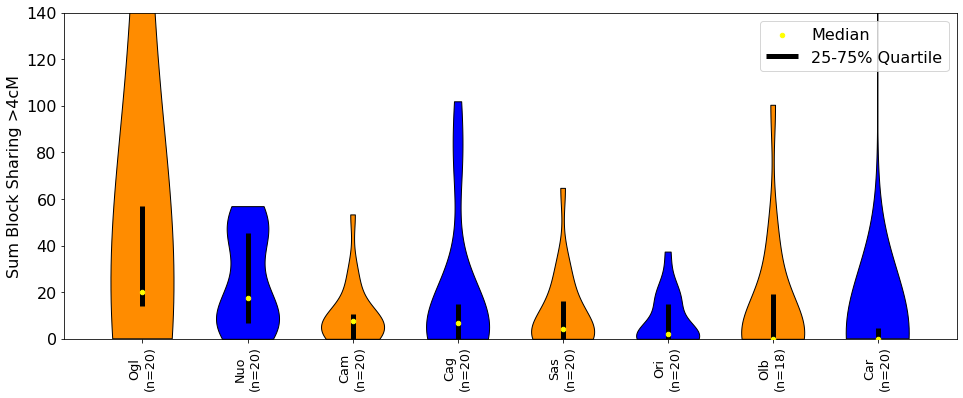

In [30]:
### A ordered List of interesting populations
path_rohs_info_mod = "./Empirical/1240k/modern_roh_summary.csv"
df_roh_info = pd.read_csv(path_rohs_info_mod)
print(f"Loaded {len(df_roh_info)} Individuals")

### Load Modern Meta
meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df = pd.read_csv(meta_path)  # Load the Meta File
full_df = pd.merge(df_roh_info, meta_df[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")
group_df = full_df.groupby("clst")  # Group by Population

pop_list = ["Ogl", "Nuo", "Cag", "Car", "Cam", "Ori", "Sas", "Olb"]

colors_mod = ["darkorange", "blue"] * (len(pop_list)//2) + ["orange"] * (len(pop_list) % 2)

roh_vecs_mod = np.array([get_summary_roh(group_df, pop) for pop in pop_list])
pop_nrs = [len(roh_vec) for roh_vec in roh_vecs_mod]
pop_labels_mod = np.array([pop_list[i] + '\n(n=' + str(pop_nrs[i]) + ')' for i in range(len(pop_nrs))])

### Sort by ROH Sharing
inds = sort_rohs(roh_vecs_mod)[::-1]

plot_roh_violin(roh_vecs_mod[inds], pop_labels_mod[inds], colors_mod, savepath = "", rot_label=90)

# Analyze Ancient Populations with original Labels
Use all original Labels, to have very fine-scale resolution

In [6]:
### Read the Meta File
meta_path_org = "./Data/Marcus2019_1240k/meta_rev.csv"
#meta_path = "./Data/Marcus2019_1240k/meta_rev_unique_ids.csv"
meta_df_org = pd.read_csv(meta_path_org)  # Load the Meta File
anc_sardind= 85
anc_ind =  1087

### Load the original Data
path_rohs_info = "./Empirical/1240k/ancsards_roh_summary.csv"
df_roh_info = pd.read_csv(path_rohs_info)
print(f"Loaded {len(df_roh_info)} Individuals")

full_df = pd.merge(df_roh_info, meta_df_org[["iid","n_cov_snp", "age", "clst", "mean_cov"]], on="iid", how="left")
group_df = full_df.groupby("clst")  # Group by Population

Loaded 557 Individuals


In [130]:
def get_group_df_statistics(min_n=5):
    "min_n: Minimum Number of Populations per Group"
    summary_df = group_df.agg(
        {'iid': "count",
             'sum_roh': "median",
            'max_roh': "median",
             "age": "median"
        })

    summary_df.sort_values(by="age", ascending=False, inplace=True)
    summary_df = summary_df[summary_df["iid"] >= min_n]
    return summary_df

## Plot Each Population as a Pile with ROH estimate 
And alternate Colors

In [143]:
summary_df = get_group_df_statistics(min_n = 10)
counts = summary_df["iid"]
x_labels = summary_df.index.values
x_labels_full = [x_labels[i] + f" (n={counts[i]})" for i in range(len(counts))]

ages_med = summary_df["age"].values
colors = ["red", "blue"]     # The two alternating Colors
colors_all = [colors[i%2] for i in np.arange(len(x_labels))]

In [144]:
def plot_column_roh(ylim=[]):
    fs = 12
    s= 10
    bw = 0.4

    plt.figure(figsize=(14,6))
    ax = plt.gca()

    ### Do the Group Plots
    for i, pop in enumerate(x_labels):
        sum_roh_vals = group_df.get_group(pop)["sum_roh"].values   
        c = colors[i%2]
        ax.plot([i - bw, i + bw], [np.median(sum_roh_vals),]*2, c="black", lw=3, zorder=0)
        
        x_jitter = -0.4 + np.random.random(len(sum_roh_vals))*0.8
        ax.scatter(i + x_jitter, sum_roh_vals, s=s, c=c, zorder=1, alpha=1)

    ### Set the x-Labels
    ax.get_xaxis().set_tick_params(direction='out', rotation=90)
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xticks(np.arange(len(ages_med)))  
    #ax.set_xticklabels(x_labels, fontsize = 12)
    ax.set_xticklabels(x_labels_full, fontsize = fs)
    [t.set_color(i) for (i,t) in
         zip(colors_all, ax.xaxis.get_ticklabels())]  # Set the X-Label Colors

    ax.set_ylabel("Sum ROH >4cM", fontsize = fs)
    
    if len(ylim)==2:
        ax.set_ylim(ylim)
    plt.show()

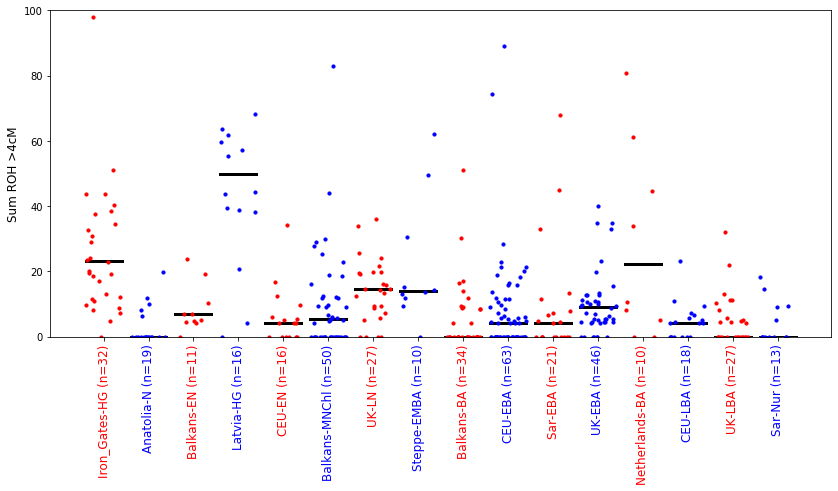

In [145]:
plot_column_roh(ylim=[0, 100])

# Area 51

In [26]:
full_df[full_df["clst"]=="Mycenaean-BA"]

,iid,max_roh,sum_roh,n_roh,n_cov_snp,age,clst,mean_cov
6,I9006,62.245902,215.232998,11,357533,3286.5,Mycenaean-BA,1.389786
35,I9041,23.858202,68.493795,5,409806,3400.0,Mycenaean-BA,1.558717
